In [1]:
import mlflow
from camelyon.log_ops import TRACKING_URI

mlflow.set_tracking_uri(TRACKING_URI)

/tmp/ipykernel_973563/1686817984.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_view['params.learning'] = data_view['params.learning'].map(learning_strategy_map)
/tmp/ipykernel_973563/1686817984.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_view["params.morphology_value"] = data_view["params.morphology_value"].astype(int)


(0.4, 0.95)

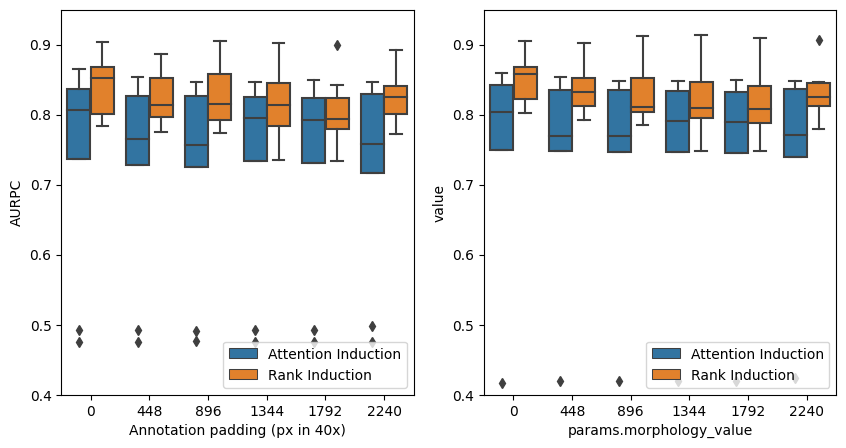

In [2]:
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt

rows = list()

for random_state in range(2018, 2027):
    for morphology_value in [448, 896, 1344, 1792, 2240]:
        query_rows = mlflow.search_runs(
            experiment_names=["attention_induction"], 
            filter_string=(
            f"params.learning = 'attention_induction' "
            "AND params.sampling_ratio = '1.0' "
            "AND params._lambda = '1.0' "
            "AND params.threshold = 'None' "
            f"AND params.random_state = '{random_state}'"
            f"AND params.morphology_value = '{morphology_value}'"
            )
        )

        if not query_rows.empty and "metrics.test_auroc" in query_rows.columns:
            rows.append(query_rows)
    
        query_rows = mlflow.search_runs(
            experiment_names=["attention_induction"], 
            filter_string=(
            f"params.learning = 'ltr' "
            "AND params.sampling_ratio = '1.0' "
            "AND params._lambda = '1.0' "
            f"AND params.random_state = '{random_state}'"
            f"AND params.morphology_value = '{morphology_value}'"
            )
        )

        if not query_rows.empty and "metrics.test_auroc" in query_rows.columns:
            rows.append(query_rows)

# References
for random_state in range(2018, 2027):
    query_rows = mlflow.search_runs(
        experiment_names=["attention_induction"], 
        filter_string=(
            f"params.learning = 'ltr' "
            "AND params.sampling_ratio = '1.0' "
            "AND params._lambda = '1.0' "
            f"AND params.random_state = '{random_state}' "
            f"AND params.margin = '1.0' " 
        ) # morphology_value not found d/t already recorded in mlflow
    )
    query_rows = query_rows.loc[query_rows["params.morphology_value"].isna()]
    query_rows["params.morphology_value"] = 0
    rows.append(query_rows)
    
for random_state in range(2018, 2027):
    query_rows = mlflow.search_runs(
        experiment_names=["attention_induction"], 
        filter_string=(
            f"params.learning = 'attention_induction' "
            "AND params.sampling_ratio = '1.0' "
            "AND params._lambda = '1.0' "
            f"AND params.random_state = '{random_state}'"
            "AND params.threshold = 'None' "       
        )
    )
    query_rows = query_rows.loc[query_rows["params.morphology_value"].isna()]
    query_rows["params.morphology_value"] = 0
    rows.append(query_rows)

data = pd.concat(rows)
data_view = data[["metrics.test_auroc", "metrics.test_prauc", "metrics.test_accuracy", "params.morphology_value", "params.learning"]]

# Rename
learning_strategy_map = {
    "base": "Base(AB-MIL)", 
    "attention_induction": "Attention Induction", 
    "ltr": "Rank Induction"
}
data_view['params.learning'] = data_view['params.learning'].map(learning_strategy_map)
data_view["params.morphology_value"] = data_view["params.morphology_value"].astype(int)

df_melted = data_view.melt(id_vars=["params.learning", "params.morphology_value"], var_name="metric", value_name="value")
df_melted["metric"] = df_melted["metric"].str.replace("metrics.", "", regex=False)
df_melted["metric"] = df_melted["metric"].replace({
    "test_auroc": "AUROC", 
    "test_prauc": "AUPRC", 
    "test_accuracy": "Accuracy"
})

fig, axes = plt.subplots(1, 2, figsize=(10, 5))


order = list(range(0, 1345, 448))
sns.boxplot(data=df_melted.loc[df_melted["metric"] == "AUROC"], x="params.morphology_value", y="value", hue="params.learning", ax=axes[0])
sns.boxplot(data=df_melted.loc[df_melted["metric"] == "AUPRC"], x="params.morphology_value", y="value", hue="params.learning", ax=axes[1])

axes[0].set_xlabel("Annotation padding (px in 40x)")
axes[0].set_ylabel("AUROC")
axes[0].legend(loc='lower right') 
axes[0].set_ylim(0.4, 0.95)

axes[0].set_xlabel("Annotation padding (px in 40x)")
axes[0].set_ylabel("AURPC")
axes[1].legend(loc='lower right') 
axes[1].set_ylim(0.4, 0.95)

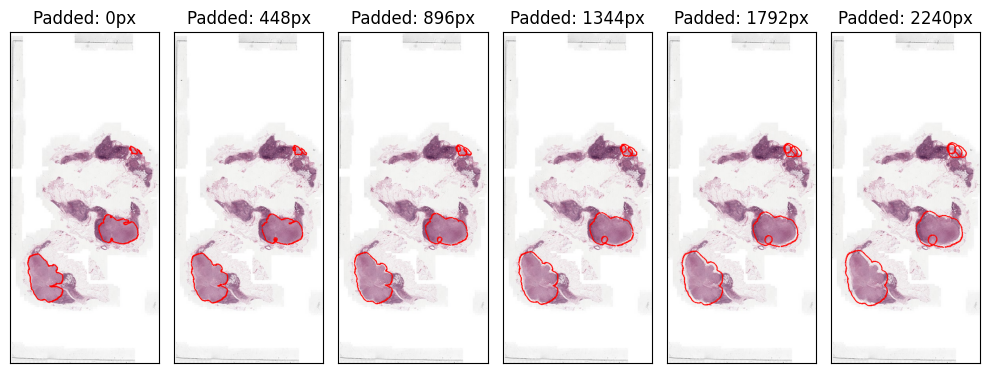

In [11]:
# Visualization
import numpy as np
from openslide import OpenSlide
from openslide.deepzoom import DeepZoomGenerator

from camelyon.data_models import Polygons

DOWNSAMPLE_RATE = 256
PADDINGS = [0, 448, 896, 1344, 1792, 2240]
fig, axes = plt.subplots(1, 6, figsize=(10, 5))

file_path = "/CAMELYON16/images/tumor_009.tif"
osr = OpenSlide(file_path)
w, h = osr.dimensions

ploygons = Polygons.from_xml(file_path.replace("images", "annotations").replace(".tif", ".xml"))

for ax, padding in zip(range(len(axes)), PADDINGS):
    canvas = np.array(osr.get_thumbnail((w//DOWNSAMPLE_RATE, h//DOWNSAMPLE_RATE)))
    for ploygon in ploygons.data:
        padded_ploygon = ploygon.buffer(padding)
        try:
            xs, ys = padded_ploygon.exterior.xy
        except Exception as e:
            padded_ploygon = ploygon
            xs, ys = padded_ploygon.exterior.xy
        
        for x, y in zip(xs, ys):
            canvas[int(y) // DOWNSAMPLE_RATE, int(x) // DOWNSAMPLE_RATE] = [255, 0, 0]
            canvas[int(y) // DOWNSAMPLE_RATE + 1, int(x) // DOWNSAMPLE_RATE + 1] = [255, 0, 0]
            canvas[int(y) // DOWNSAMPLE_RATE - 1, int(x) // DOWNSAMPLE_RATE - 1] = [255, 0, 0]
            canvas[int(y) // DOWNSAMPLE_RATE, int(x) // DOWNSAMPLE_RATE + 1] = [255, 0, 0]
            canvas[int(y) // DOWNSAMPLE_RATE + 1, int(x) // DOWNSAMPLE_RATE] = [255, 0, 0]  
    axes[ax].imshow(canvas)

for ax, padding in zip(axes, PADDINGS):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Padded: {padding}px")

plt.tight_layout()
plt.show()